In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from dateutil.parser import parse
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from pandas.plotting import autocorrelation_plot
from scipy import signal
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler

In [ ]:
train = pd.read_csv("/content/train.csv", parse_dates=['Date'], index_col='Date')
test = pd.read_csv("/content/test.csv", parse_dates=['Date'], index_col='Date')
train_index_id=pd.read_csv("/content/train.csv",index_col=0)
test_index_id=pd.read_csv("/content/test.csv",index_col=0)

In [ ]:
train.head()

,id,Open,Close,Volume,Strategy
Date,,,,,
2015-06-01,0,66.208486,75.609978,298506300,Hold
2015-06-08,1,64.116235,74.443331,227974800,Hold
2015-06-15,2,47.701942,71.140831,250670900,Buy
2015-06-22,3,54.754816,72.881344,223614300,Hold
2015-06-29,4,48.031899,66.284718,406814900,Buy


In [ ]:
train.tail()

In [ ]:
test.head()

In [ ]:
test.tail()

,id,Open,Volume
Date,,,
2022-12-26,95,57.048622,224994700
2023-01-02,96,60.569661,176020500
2023-01-09,97,61.446777,181478600
2023-01-16,98,55.447711,162471700
2023-01-23,99,57.008939,178924000


Visualizations

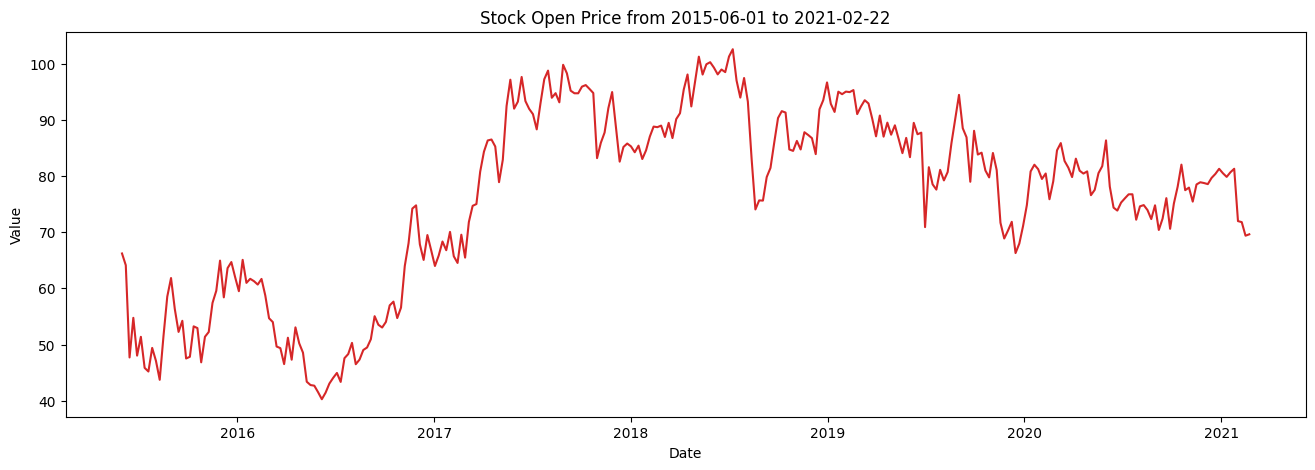

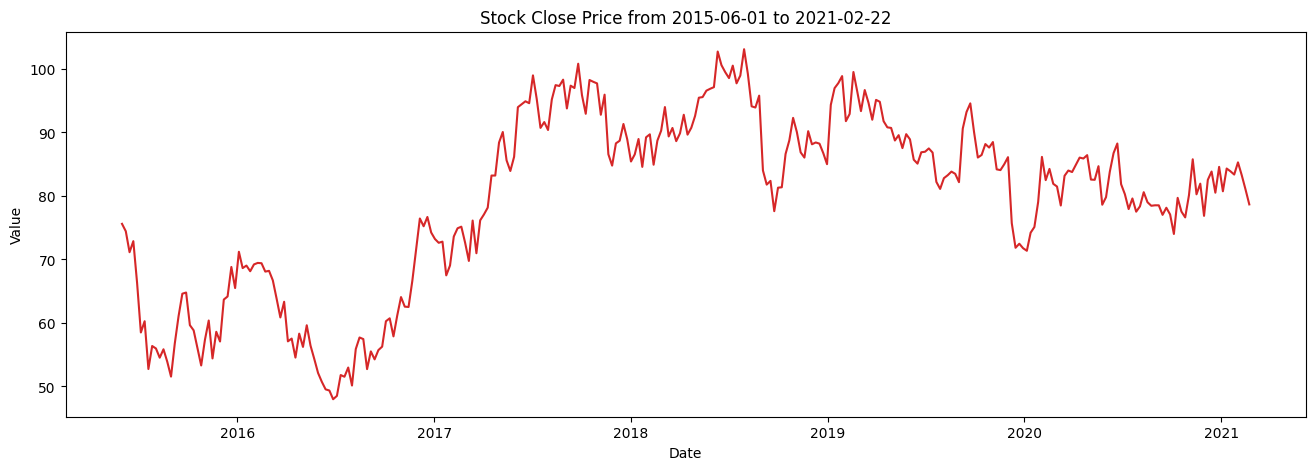

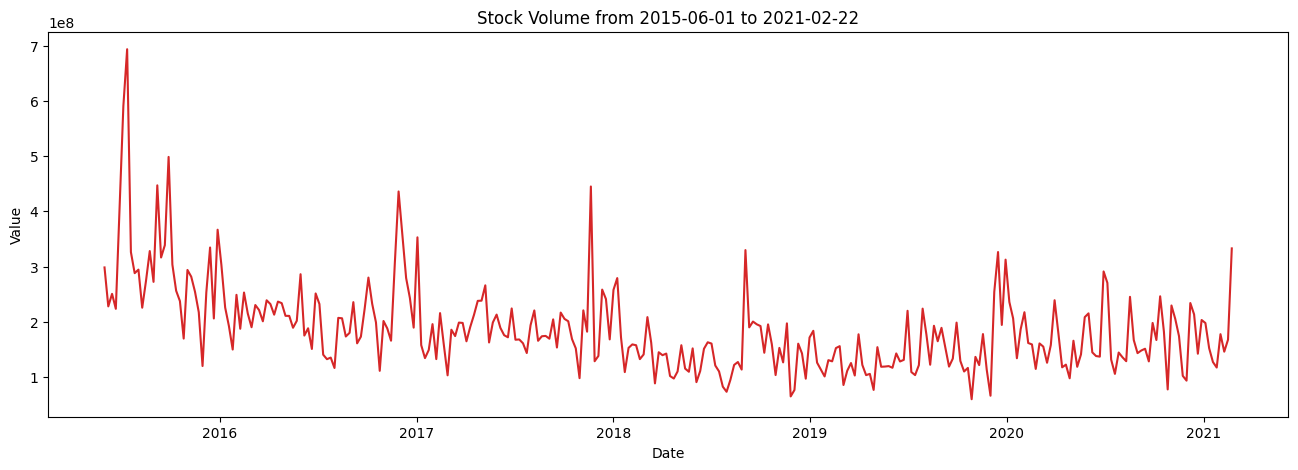

In [ ]:
def plot_df(df, x, y,title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(train, x=train.index, y=train['Open'], title='Stock Open Price from 2015-06-01 to 2021-02-22')
plot_df(train, x=train.index, y=train['Close'], title='Stock Close Price from 2015-06-01 to 2021-02-22')
plot_df(train, x=train.index, y=train['Volume'], title='Stock Volume from 2015-06-01 to 2021-02-22')

<Figure size 1600x1600 with 0 Axes>

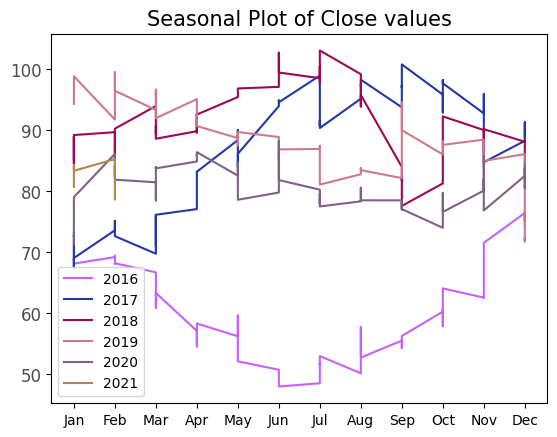

In [ ]:
df=train.copy(deep=True)
df.reset_index(inplace=True)
df.head()
df['Year'] = [d.year for d in df.Date]
df['Month'] = [d.strftime('%b') for d in df.Date]
years = df['Year'].unique()

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

plt.figure(figsize=(20,20), dpi= 80)
fig, ax = plt.subplots()
for i, y in enumerate(years):
    if i > 0:
        #print(df.loc[df.Year==y, :])
        ax.plot('Month', 'Close', data=df.loc[df.Year==y, :], color=mycolors[i], label=y)
        #ax.text(df.loc[df.Year==y, :].shape[0]-.9, df.loc[df.Year==y, 'Close'][-1:].values[0], y, fontsize=12, color=mycolors[i])
        #ax.show()

# Decoration
#ax.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Stock Close Price$', xlabel='$Month$')
ax.legend()
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Close values", fontsize=15)
plt.show()

Seasonal Decomposition(Mulplicative Decompose)

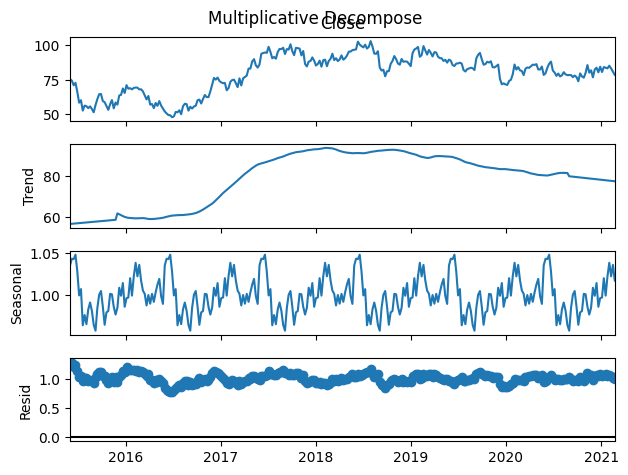

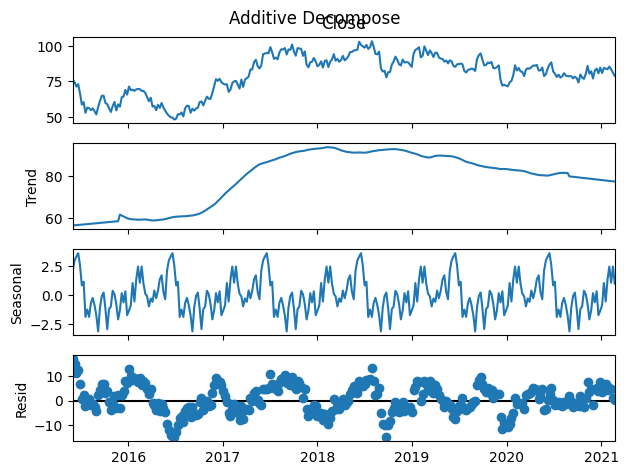

In [ ]:
result_mul = seasonal_decompose(train['Close'], model='multiplicative', extrapolate_trend='freq')

result_add = seasonal_decompose(train['Close'], model='additive', extrapolate_trend='freq')

#plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=12)
result_add.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

ADF and KPSS Test

In [ ]:
# ADF Test
result = adfuller(df.Close.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

result = adfuller(df.Close.diff().dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.Close.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.8080055426222836
p-value: 0.37649446979222034
Critial Values:
   1%, -3.4524859843440754
Critial Values:
   5%, -2.871288184343229
Critial Values:
   10%, -2.571964047565425
ADF Statistic: -19.615947588858155
p-value: 0.0
Critial Values:
   1%, -3.4524859843440754
Critial Values:
   5%, -2.871288184343229
Critial Values:
   10%, -2.571964047565425

KPSS Statistic: 1.300008
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


<ipython-input-12-c825a8ad7827>:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df.Close.values, regression='c')


DETRENDING

Text(0.5, 1.0, 'Close price detrended by subtracting the least squares fit')

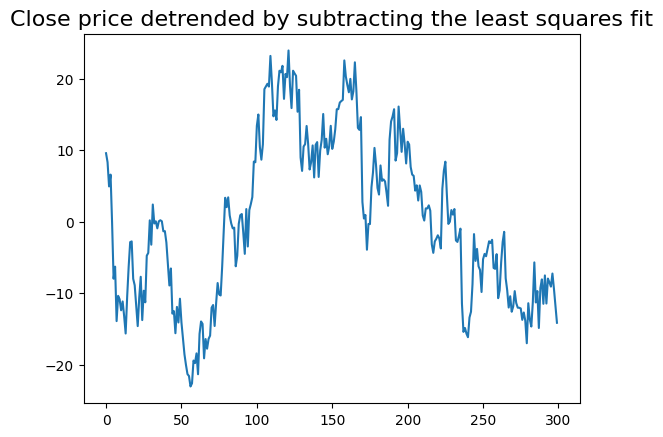

In [ ]:
detrended = signal.detrend(df.Close.values)
plt.plot(detrended)
plt.title('Close price detrended by subtracting the least squares fit', fontsize=16)

Text(0.5, 1.0, 'Close Price detrended by subtracting the trend component')

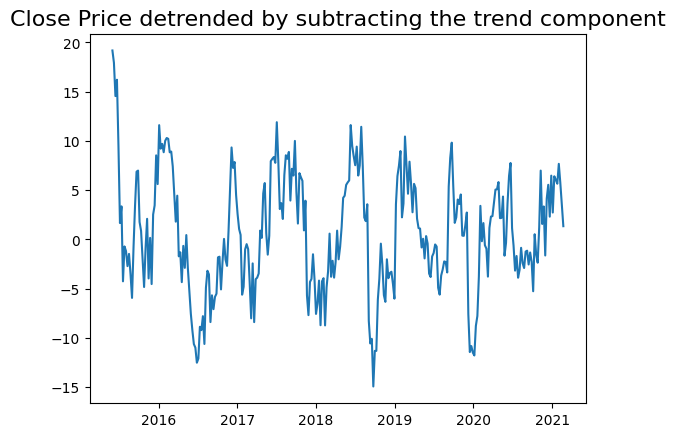

In [ ]:
detrended = df.Close.values-result_mul.trend
plt.plot(detrended)
plt.title('Close Price detrended by subtracting the trend component', fontsize=16)

DESEASONALIZE

[]

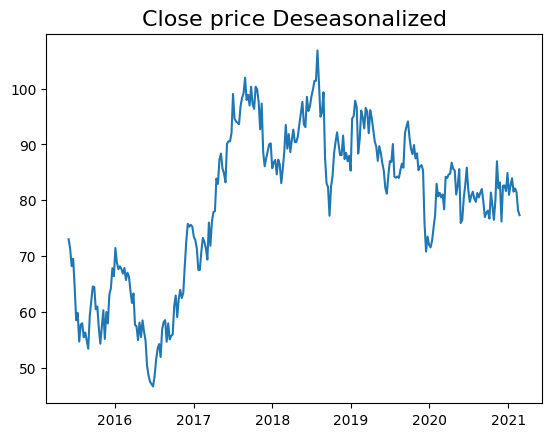

In [ ]:
# Deseasonalize
deseasonalized = df.Close.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Close price Deseasonalized', fontsize=16)
plt.plot()

Seasonality Test

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

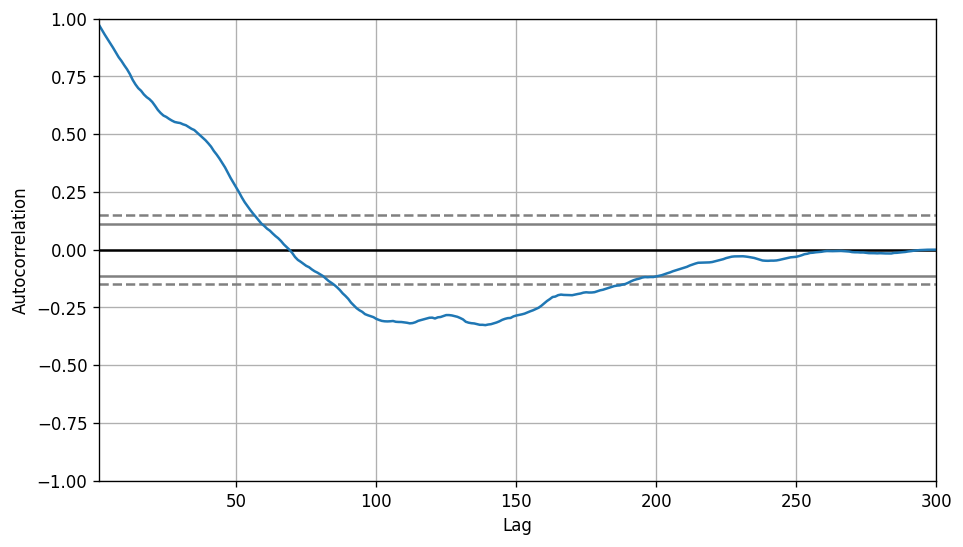

In [ ]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.Close.tolist())

ACF AND PACF (autocorrelation and partial autocorrelation)

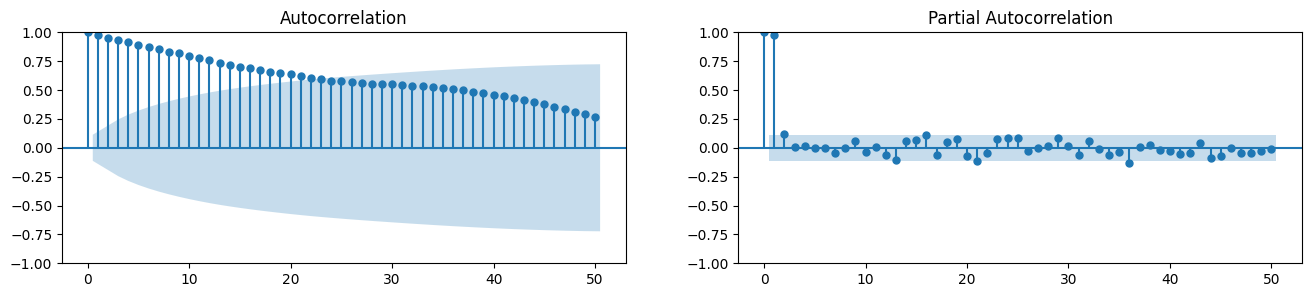

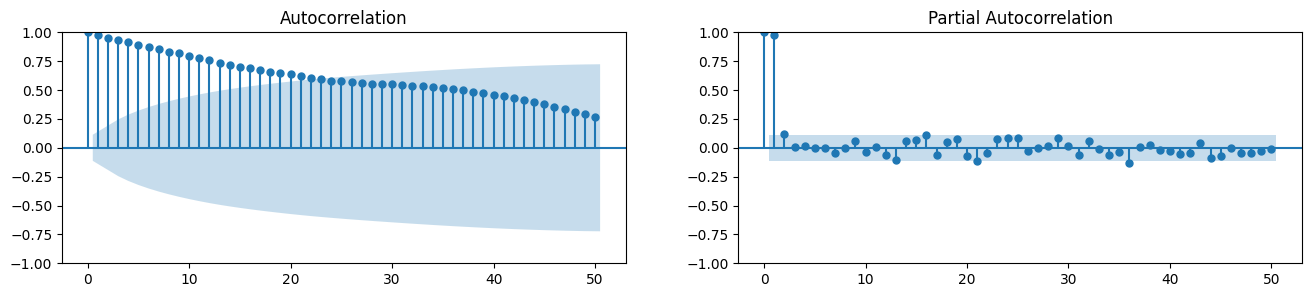

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.Close.tolist(), lags=50, ax=axes[0])
plot_pacf(df.Close.tolist(), lags=50, ax=axes[1])

Here we choose p=2 and q=0 as ACF plot is exponentially decreasing and PACF plot drops to zero after two lags

In [ ]:
# hope we didnt messup the imported datasets
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

We have stock data from 2015-06-01 to 2021-02-22 (300 instances/days) with frequency of weeks(7 days) and we are expected to forecast
Tried few traditional stockprice prediction algorithms

In [ ]:
"""# Assuming you have a DataFrame named 'df' with a 'Close' column
# Define the period for Bollinger Bands (e.g., 20 periods) and the number of standard deviations (e.g., 2)
period = 14
num_std_dev = 1

df = train
# Calculate the rolling mean and rolling standard deviation
df['SMA'] = df['Close'].rolling(window=period).mean()
df['STD'] = df['Close'].rolling(window=period).std()

# Calculate the upper and lower Bollinger Bands
df['Upper Bollinger Band'] = df['SMA'] + (num_std_dev * df['STD'])
df['Lower Bollinger Band'] = df['SMA'] - (num_std_dev * df['STD'])

# Initialize a 'Signal' column to hold the trading signals
df['Signal'] = 'Hold'

# Apply the buy, sell, hold logic based on Bollinger Bands
for i in range(len(df)):
    if df['Close'].iloc[i] > df['Upper Bollinger Band'].iloc[i]:
        df.at[i, 'Signal'] = 'Sell'
    elif df['Close'].iloc[i] < df['Lower Bollinger Band'].iloc[i]:
        df.at[i, 'Signal'] = 'Buy'

# Print the DataFrame with trading signals
print(df[['Date', 'Close', 'Upper Bollinger Band', 'Lower Bollinger Band', 'Signal']])

df.to_csv("/kaggle/working/train_strategy_testing_bb.csv")
"""


In [ ]:
"""df = train

# Assuming you have a DataFrame named 'df' with a 'Close' column
# Calculate daily price changes
df['Price Change'] = df['Close'].diff()

# Define the period for RSI calculation (e.g., 14 periods)
period = 14

# Calculate average gains and losses
df['Gain'] = df['Price Change'].apply(lambda x: x if x > 0 else 0)
df['Loss'] = df['Price Change'].apply(lambda x: -x if x < 0 else 0)

df['Average Gain'] = df['Gain'].rolling(window=period).mean()
df['Average Loss'] = df['Loss'].rolling(window=period).mean()

# Calculate relative strength (RS)
df['RS'] = df['Average Gain'] / df['Average Loss']

# Calculate the RSI
df['RSI'] = 100 - (100 / (1 + df['RS']))

# Drop the NaN values resulting from rolling mean calculations
#df = df.dropna()

# Define RSI threshold values for trading decisions
rsi_overbought_threshold = 58
rsi_oversold_threshold = 38

# Initialize a 'Signal' column to hold the trading signals
df['Signal'] = 'Hold'

# Apply the buy, sell, hold logic based on RSI values
for i in range(len(df)):
    if df['RSI'].iloc[i] > rsi_overbought_threshold:
        df.at[i, 'Signal'] = 'Sell'
    elif df['RSI'].iloc[i] < rsi_oversold_threshold:
        df.at[i, 'Signal'] = 'Buy'

# Print the DataFrame with RSI values and trading signals
print(df[['Date', 'Close', 'RSI', 'Signal']])

df.to_csv("/kaggle/working/train_strategy_testing_rsi.csv")"""

In [ ]:
"""df = train
# Assuming you have a DataFrame named 'df' with a 'Close' column
# Define the period for the Stochastic Oscillator (e.g., 14 periods)
stochastic_period = 13

# Calculate the lowest and highest closing prices over the Stochastic period
df['Lowest Low'] = df['Close'].rolling(window=stochastic_period).min()
df['Highest High'] = df['Close'].rolling(window=stochastic_period).max()

# Calculate the %K, which measures the position of the closing price relative to the range
df['%K'] = ((df['Close'] - df['Lowest Low']) / (df['Highest High'] - df['Lowest Low'])) * 100

# Define overbought and oversold thresholds (e.g., 80 and 20)
overbought_threshold = 60
oversold_threshold = 30

# Initialize a 'Signal' column to hold the trading signals
df['Signal'] = 'Hold'

# Apply the buy, sell, hold logic based on Stochastic Oscillator
for i in range(len(df)):
    if df['%K'].iloc[i] > overbought_threshold:
        df.at[i, 'Signal'] = 'Sell'
    elif df['%K'].iloc[i] < oversold_threshold:
        df.at[i, 'Signal'] = 'Buy'

# Print the DataFrame with Stochastic Oscillator values and trading signals
print(df[['Date', 'Close', '%K', 'Signal']])
df.to_csv("/kaggle/working/train_strategy_testing_so.csv")"""

Feature engineering

In [ ]:
# percentage change lags
train["Open_pct_change"] = train["Open"].pct_change() * 100
train["Open_pct_change"].fillna(method='bfill', inplace=True)
train["Volume_pct_change"] = train["Volume"].pct_change() *100
train["Volume_pct_change"].fillna(method='bfill', inplace=True)

test["Open_pct_change"] = test["Open"].pct_change() * 100
test["Open_pct_change"].fillna(method='bfill', inplace=True)
test["Volume_pct_change"] = test["Volume"].pct_change() *100
test["Volume_pct_change"].fillna(method='bfill', inplace=True)

#lag_periods = 7  # Adjust the lag period as needed
for lag_periods in range(1,8):
    for col in ['Open_pct_change', 'Volume_pct_change']:
        train[f'{col}_lag{lag_periods}'] = train[col].shift(lag_periods)
        train[f'{col}_lag{lag_periods}'].fillna(method='bfill', inplace=True)

        test[f'{col}_lag{lag_periods}'] = test[col].shift(lag_periods)
        test[f'{col}_lag{lag_periods}'].fillna(method='bfill', inplace=True)

<ipython-input-20-1fa0b8dbaa79>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train["Open_pct_change"].fillna(method='bfill', inplace=True)
<ipython-input-20-1fa0b8dbaa79>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train["Volume_pct_change"].fillna(method='bfill', inplace=True)
<ipython-input-20-1fa0b8dbaa79>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test["Open_pct_change"].fillna(method='bfill', inplace=True)
<ipython-input-20-1fa0b8dbaa79>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test["Volume_pct_change"].fillna(method='bfill', inplace=True)
<ipython-input-20-1fa0b8dbaa79>:16: FutureWarning: Series.fillna with

In [ ]:
# Calculate rolling means for 'Open' and 'Volume'
window_size = 7  # Adjust the window size as needed
for col in ['Open', 'Volume']:
    train[f'{col}_rolling_mean'] =train[col].rolling(window=window_size).mean()
    train[f'{col}_rolling_mean'].fillna(method='bfill', inplace=True)

    test[f'{col}_rolling_mean'] =test[col].rolling(window=window_size).mean()
    test[f'{col}_rolling_mean'].fillna(method='bfill', inplace=True)

<ipython-input-21-f7d22a244ebd>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[f'{col}_rolling_mean'].fillna(method='bfill', inplace=True)
<ipython-input-21-f7d22a244ebd>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[f'{col}_rolling_mean'].fillna(method='bfill', inplace=True)
<ipython-input-21-f7d22a244ebd>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[f'{col}_rolling_mean'].fillna(method='bfill', inplace=True)
<ipython-input-21-f7d22a244ebd>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[f'{col}_rolling_mean'].fillna(method='bfill', inplace=True)


In [ ]:
# Create differenced values for 'Open' and 'Volume'
for col in ['Open', 'Volume']:
    train[f'{col}_diff'] =train[col].diff()
    train[f'{col}_diff'].fillna(method='bfill', inplace=True)

    test[f'{col}_diff'] =test[col].diff()
    test[f'{col}_diff'].fillna(method='bfill', inplace=True)


<ipython-input-22-311e6ef7cb9c>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[f'{col}_diff'].fillna(method='bfill', inplace=True)
<ipython-input-22-311e6ef7cb9c>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[f'{col}_diff'].fillna(method='bfill', inplace=True)
<ipython-input-22-311e6ef7cb9c>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[f'{col}_diff'].fillna(method='bfill', inplace=True)
<ipython-input-22-311e6ef7cb9c>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[f'{col}_diff'].fillna(method='bfill', inplace=True)


In [ ]:
# Calculate moving averages for 'Open' and 'Volume'
ma_window_size = 8  # Adjust the moving average window size as needed
for col in ['Open', 'Volume']:
    train[f'{col}_moving_average'] = train[col].rolling(window=ma_window_size).mean()
    train[f'{col}_moving_average'].fillna(method='bfill', inplace=True)

    test[f'{col}_moving_average'] = test[col].rolling(window=ma_window_size).mean()
    test[f'{col}_moving_average'].fillna(method='bfill', inplace=True)

<ipython-input-23-5e15ca15a00d>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[f'{col}_moving_average'].fillna(method='bfill', inplace=True)
<ipython-input-23-5e15ca15a00d>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[f'{col}_moving_average'].fillna(method='bfill', inplace=True)
<ipython-input-23-5e15ca15a00d>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[f'{col}_moving_average'].fillna(method='bfill', inplace=True)
<ipython-input-23-5e15ca15a00d>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[f'{col}_moving_average'].fillna(method='bfill', inplace=True)


In [ ]:
train['Date'] = pd.to_datetime(train['Date'])

train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
train['day'] = train['Date'].dt.day

#df['dayofweek_num'] = df['Date'].dt.dayofweek
#df['dayofweek_name'] = df['Date'].dt.day_name()  # Use day_name() to get the day of the week name

test['Date'] = pd.to_datetime(test['Date'])

test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
test['day'] = test['Date'].dt.day

In [ ]:
# Convert the 'Date' column to DateTime data type
#df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index of the DataFrame
train.set_index('Date', inplace=True)

# Now, you can perform the seasonal decomposition
for col in ['Open', 'Volume']:

    result = seasonal_decompose(train[col], model='multiplicative')
    train[f'{col}_trend'] = result.trend
    train[f'{col}_trend'].interpolate(method='linear', inplace=True)
    train[f'{col}_trend'].interpolate(method='linear', limit_direction='backward', inplace=True)
    train[f'{col}_seasonal'] = result.seasonal
    train[f'{col}_residual'] = result.resid
    train[f'{col}_residual'].interpolate(method='linear', inplace=True)
    train[f'{col}_residual'].interpolate(method='linear', limit_direction='backward', inplace=True)

In [ ]:
test.set_index('Date', inplace=True)

for col in ['Open', 'Volume']:
    result = seasonal_decompose(test[col], model='multiplicative', period=int(len(test)/2))
    test[f'{col}_trend'] = result.trend
    test[f'{col}_trend'].interpolate(method='linear', inplace=True)
    test[f'{col}_trend'].interpolate(method='linear', limit_direction='backward', inplace=True)
    test[f'{col}_seasonal'] = result.seasonal
    test[f'{col}_residual'] = result.resid
    test[f'{col}_residual'].interpolate(method='linear', inplace=True)
    test[f'{col}_residual'].interpolate(method='linear', limit_direction='backward', inplace=True)

In [ ]:
train.to_csv("train_components.csv")

In [ ]:
train.columns

Index(['id', 'Open', 'Close', 'Volume', 'Strategy', 'Open_pct_change',
       'Volume_pct_change', 'Open_pct_change_lag1', 'Volume_pct_change_lag1',
       'Open_pct_change_lag2', 'Volume_pct_change_lag2',
       'Open_pct_change_lag3', 'Volume_pct_change_lag3',
       'Open_pct_change_lag4', 'Volume_pct_change_lag4',
       'Open_pct_change_lag5', 'Volume_pct_change_lag5',
       'Open_pct_change_lag6', 'Volume_pct_change_lag6',
       'Open_pct_change_lag7', 'Volume_pct_change_lag7', 'Open_rolling_mean',
       'Volume_rolling_mean', 'Open_diff', 'Volume_diff',
       'Open_moving_average', 'Volume_moving_average', 'year', 'month', 'day',
       'Open_trend', 'Open_seasonal', 'Open_residual', 'Volume_trend',
       'Volume_seasonal', 'Volume_residual'],
      dtype='object')

In [ ]:
train

,id,Open,Close,Volume,Strategy,Open_pct_change,Volume_pct_change,Open_pct_change_lag1,Volume_pct_change_lag1,Open_pct_change_lag2,...,Volume_moving_average,year,month,day,Open_trend,Open_seasonal,Open_residual,Volume_trend,Volume_seasonal,Volume_residual
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-01,0,66.208486,75.609978,298506300,Hold,-3.160094,-23.628145,-3.160094,-23.628145,-3.160094,...,377279187.5,2015,6,1,53.680153,1.008764,1.153658,2.726466e+08,1.108305,0.484160
2015-06-08,1,64.116235,74.443331,227974800,Hold,-3.160094,-23.628145,-3.160094,-23.628145,-3.160094,...,377279187.5,2015,6,8,53.680153,1.007769,1.153658,2.726466e+08,0.904274,0.484160
2015-06-15,2,47.701942,71.140831,250670900,Buy,-25.600838,9.955530,-3.160094,-23.628145,-3.160094,...,377279187.5,2015,6,15,53.680153,1.011638,1.153658,2.726466e+08,0.888275,0.484160
2015-06-22,3,54.754816,72.881344,223614300,Hold,14.785299,-10.793674,-25.600838,9.955530,-3.160094,...,377279187.5,2015,6,22,53.680153,0.994279,1.153658,2.726466e+08,0.875001,0.484160
2015-06-29,4,48.031899,66.284718,406814900,Buy,-12.278220,81.927050,14.785299,-10.793674,-25.600838,...,377279187.5,2015,6,29,53.680153,0.992179,1.153658,2.726466e+08,1.043683,0.484160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,295,81.284821,83.373498,117281600,Sell,0.769968,-7.832265,1.031462,-16.374273,-0.807887,...,173485000.0,2021,1,25,77.640484,1.030852,0.955997,1.653291e+08,0.963305,1.069003
2021-02-01,296,71.970249,85.294903,177655800,Sell,-11.459177,51.477981,0.769968,-7.832265,1.031462,...,166430325.0,2021,2,1,77.640484,1.016968,0.955997,1.653291e+08,0.939737,1.069003
2021-02-08,297,71.784627,83.266453,146003500,Hold,-0.257915,-17.816643,-11.459177,51.477981,0.769968,...,157986887.5,2021,2,8,77.640484,1.022378,0.955997,1.653291e+08,1.006306,1.069003


Forecasting


SARIMAX (we tried ARIMA, ARIMAX and many other models but this updated file contains only SARIMAX :) )

In [ ]:
# include all columns and see what is significant
import statsmodels.api as sm
sarimax_model = sm.tsa.statespace.SARIMAX(train['Close'],order=(1,1,1),seasonal_order=(2,1,0,52),exog = train[['Open_pct_change',
       'Volume_pct_change', 'Open_pct_change_lag1', 'Volume_pct_change_lag1',
       'Open_pct_change_lag2', 'Volume_pct_change_lag2',
       'Open_pct_change_lag3', 'Volume_pct_change_lag3',
       'Open_pct_change_lag4', 'Volume_pct_change_lag4',
       'Open_rolling_mean',
       'Volume_rolling_mean', 'Open_diff', 'Volume_diff',
       'Open_moving_average', 'Volume_moving_average',
       'Open_trend', 'Open_seasonal', 'Open_residual', 'Volume_trend',
       'Volume_seasonal', 'Volume_residual']],
                                enforce_stationarity=False, enforce_invertibility=False)
sarimax_model_fit=sarimax_model.fit()
sarimax_model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 52)   Log Likelihood                -331.718
Date:                             Thu, 12 Sep 2024   AIC                            717.437
Time:                                     15:53:27   BIC                            797.244
Sample:                                 06-01-2015   HQIC                           749.867
                                      - 02-22-2021                                         
Covariance Type:                               opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Open_pct_change           -0.1175      0.039     -3.013      0.003      -0.194      -0.041
Volume_pct_change         -0.0176      0.015     -1.149      0.251      -0.048       0.012
Open_pct_change_lag1      -0.2240      0.057     -3.905      0.000      -0.336      -0.112
Volume_pct_change_lag1    -0.0139      0.010     -1.356      0.175      -0.034       0.006
Open_pct_change_lag2      -0.2899      0.058     -5.008      0.000      -0.403      -0.176
Volume_pct_change_lag2    -0.0100      0.013     -0.790      0.429      -0.035       0.015
Open_pct_change_lag3       0.0670      0.055      1.221      0.222      -0.041       0.175
Volume_pct_change_lag3    -0.0101      0.012     -0.842      0.400      -0.034       0.013
Open_pct_change_lag4       0.1161      0.052      2.241      0.025       0.015       0.218
Volume_pct_change_lag4    -0.0035      0.009     -0.380      0.704      -0.022       0.015
Open_rolling_mean          0.8230      0.061     13.599      0.000       0.704       0.942
Volume_rolling_mean    -1.345e-08    4.5e-08     -0.299      0.765   -1.02e-07    7.47e-08
Open_diff                 -0.0269      0.029     -0.941      0.347      -0.083       0.029
Volume_diff             3.593e-09   1.09e-08      0.330      0.741   -1.77e-08    2.49e-08
Open_moving_average       -0.0841      0.056     -1.505      0.132      -0.194       0.025
Volume_moving_average   1.268e-08   4.21e-08      0.301      0.763   -6.98e-08    9.51e-08
Open_trend                 0.0343      0.002     15.900      0.000       0.030       0.038
Open_seasonal           2.476e-16      2e-08   1.24e-08      1.000   -3.92e-08    3.92e-08
Open_residual              0.7396      0.001    778.496      0.000       0.738       0.741
Volume_trend           -1.112e-08   8.89e-08     -0.125      0.900   -1.85e-07    1.63e-07
Volume_seasonal                 0   1.65e-08          0      1.000   -3.23e-08    3.23e-08
Volume_residual            1.1867      0.001   1000.610      0.000       1.184       1.189
ar.L1                      0.1338      0.059      2.269      0.023       0.018       0.249
ma.L1                     -0.7298      0.066    -10.975      0.000      -0.860      -0.599
ar.S.L52                  -0.5122      0.075     -6.873      0.000      -0.658      -0.366
ar.S.L104                 -0.2840      0.074     -3.816      0.000      -0.430      -0.138
sigma2                     8.0169      0.002   3469.922      0.000       8.012       8.021
===================================================================================
Ljung-Box (L1) (Q):                   2.45   Jarque-Bera (JB):                 1.80
Prob(Q):                              0.12   Prob(JB):                         0.41
Heteroskedasticity (H):               0.83   Skew:                             0.28
Prob(H) (two-sided):                  0.51   Kurtosis:    

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.75e+30. Standard errors may be unstable

Consider the features that have a P value lesser than 0.05 and have a significant coeff as exog variables

In [ ]:
#train test slop from train dataset 80-20 with the significant features
# Define the size of the training set
train_size = int(len(train) * 0.8)  # 80% of the data for training

# Split the data into training and testing subsets
train_val, test_val = train.iloc[:train_size], train.iloc[train_size:]

sarimax_model = sm.tsa.statespace.SARIMAX(train_val['Close'],order=(1,1,1),seasonal_order=(2,1,0,52),exog = train_val[['Open_pct_change',
       'Open_pct_change_lag1',
       'Open_pct_change_lag2',
       'Open_pct_change_lag4','Open_rolling_mean',
       'Open_trend',
       'Open_residual', 'Volume_residual']],
        enforce_stationarity=False, enforce_invertibility=False)

sarimax_model_fit=sarimax_model.fit()


# Forecast 'Close' prices for the test subset
forecasted_values = sarimax_model_fit.forecast(steps=len(test_val),exog = test_val[['Open_pct_change',
       'Open_pct_change_lag1',
       'Open_pct_change_lag2',
       'Open_pct_change_lag4','Open_rolling_mean',
       'Open_trend',
       'Open_residual', 'Volume_residual']])

# Compare the forecast with the actual values in the test set
# (for example, using SMAPE)
def calculate_smape(y_true, y_pred):
    smape = 100 * (2 * abs(y_pred - y_true) / (abs(y_pred) + abs(y_true))).mean()
    return smape

smape_score = calculate_smape(test_val['Close'], forecasted_values)
print("\n")
print(f" SMAPE Score: {smape_score}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




 SMAPE Score: 2.563395110030236


In [ ]:
pred_sarimax = sarimax_model_fit.predict(train.index[-60],train.index[-1],exog = train[train.index[-60]:train.index[-1]][['Open_pct_change',
       'Open_pct_change_lag1',
       'Open_pct_change_lag2',
       'Open_pct_change_lag4','Open_rolling_mean',
       'Open_trend',
       'Open_residual', 'Volume_residual']])
print('SARIMAX model MSE:{}'.format(mean_squared_error(train[train.index[-60]:]['Close'],pred_sarimax)))

SARIMAX model MSE:6.951802339916231


<Figure size 1440x840 with 0 Axes>

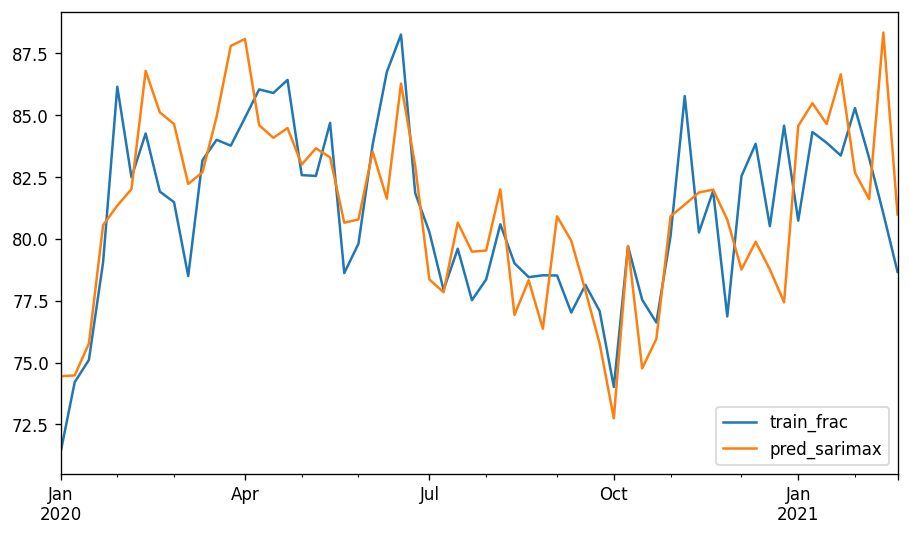

In [ ]:
plt.figure(figsize=(12,7))
pd.DataFrame({'train_frac':train[train.index[-60]:]['Close'],'pred_sarimax':pred_sarimax}).plot();plt.show()

In [ ]:
#finally fitting the model with all the significant features
sarimax_model = sm.tsa.statespace.SARIMAX(train['Close'],order=(1,1,1),seasonal_order=(2,1,0,52),exog = train[['Open_pct_change',
       'Open_pct_change_lag1',
       'Open_pct_change_lag2',
       'Open_pct_change_lag4','Open_rolling_mean',
       'Open_trend',
       'Open_residual', 'Volume_residual']],
                                enforce_stationarity=False, enforce_invertibility=False)
sarimax_model_fit=sarimax_model.fit()
sarimax_model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 52)   Log Likelihood                -318.999
Date:                             Thu, 12 Sep 2024   AIC                            663.999
Time:                                     16:19:19   BIC                            702.424
Sample:                                 06-01-2015   HQIC                           679.613
                                      - 02-22-2021                                         
Covariance Type:                               opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Open_pct_change         -0.1348      0.059     -2.271      0.023      -0.251      -0.018
Open_pct_change_lag1    -0.2135      0.057     -3.727      0.000      -0.326      -0.101
Open_pct_change_lag2    -0.2694      0.040     -6.668      0.000      -0.349      -0.190
Open_pct_change_lag4     0.1036      0.041      2.516      0.012       0.023       0.184
Open_rolling_mean        0.8460      0.084     10.024      0.000       0.681       1.011
Open_trend              -0.0212      0.089     -0.237      0.813      -0.196       0.154
Open_residual            4.1429      6.430      0.644      0.519      -8.460      16.746
Volume_residual         -0.8954      0.804     -1.113      0.266      -2.472       0.681
ar.L1                    0.0751      0.099      0.762      0.446      -0.118       0.268
ma.L1                   -0.9997      1.971     -0.507      0.612      -4.863       2.864
ar.S.L52                -0.5696      0.084     -6.784      0.000      -0.734      -0.405
ar.S.L104               -0.1831      0.081     -2.268      0.023      -0.341      -0.025
sigma2                   5.0913      9.927      0.513      0.608     -14.365      24.548
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.83   Prob(JB):                         0.31
Heteroskedasticity (H):               0.79   Skew:                             0.30
Prob(H) (two-sided):                  0.43   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step)

In [36]:
forecast_sarimax = sarimax_model_fit.predict(test.index[0],test.index[-1],exog = test[['Open_pct_change',
       'Open_pct_change_lag1',
       'Open_pct_change_lag2',
       'Open_pct_change_lag4','Open_rolling_mean',
       'Open_trend',
       'Open_residual', 'Volume_residual']])

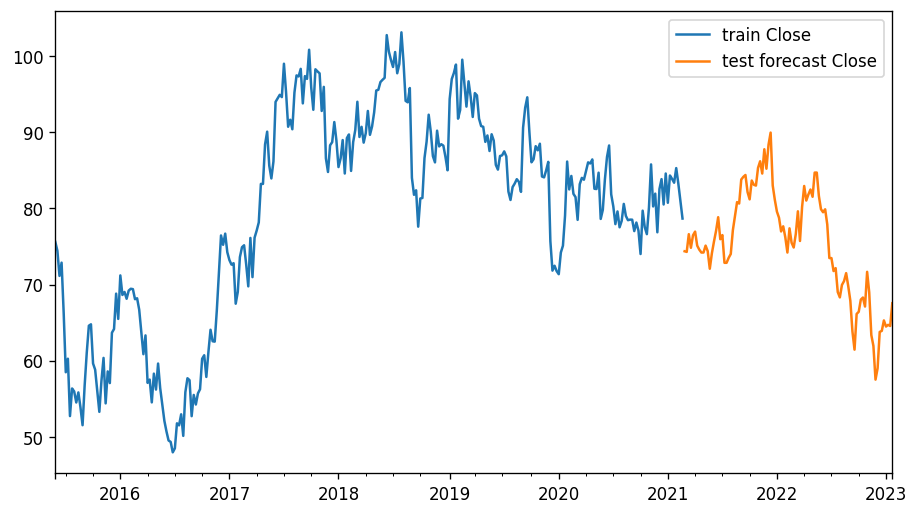

In [37]:
pd.DataFrame({'train Close ':train['Close'],'test forecast Close':forecast_sarimax}).plot();plt.show()

In [38]:
test["Close"] = forecast_sarimax
# Assuming you have a DataFrame 'data' with your features and labels
X = train.drop(columns=['Strategy',"id"])  # Features
y = train['Strategy']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

BUY SELL HOLD Strategy predictions
Tried using Random Forest to narrow down the features to include for classification of Buy Sell Hold. (usless, skip to logistic regression

                   Feature  Importance
1                    Close    0.080270
11    Open_pct_change_lag4    0.050876
19       Open_rolling_mean    0.044662
0                     Open    0.042659
30           Open_residual    0.040145
23     Open_moving_average    0.039452
31            Volume_trend    0.039290
17    Open_pct_change_lag7    0.035503
33         Volume_residual    0.035277
14  Volume_pct_change_lag5    0.034144
28              Open_trend    0.031064
9     Open_pct_change_lag3    0.029958
12  Volume_pct_change_lag4    0.026799
3          Open_pct_change    0.026767
15    Open_pct_change_lag6    0.026765
18  Volume_pct_change_lag7    0.026074
13    Open_pct_change_lag5    0.026073
24   Volume_moving_average    0.024991
10  Volume_pct_change_lag3    0.024580
16  Volume_pct_change_lag6    0.024057
29           Open_seasonal    0.023554
21               Open_diff    0.023508
27                     day    0.023237
20     Volume_rolling_mean    0.022860
26                   mont

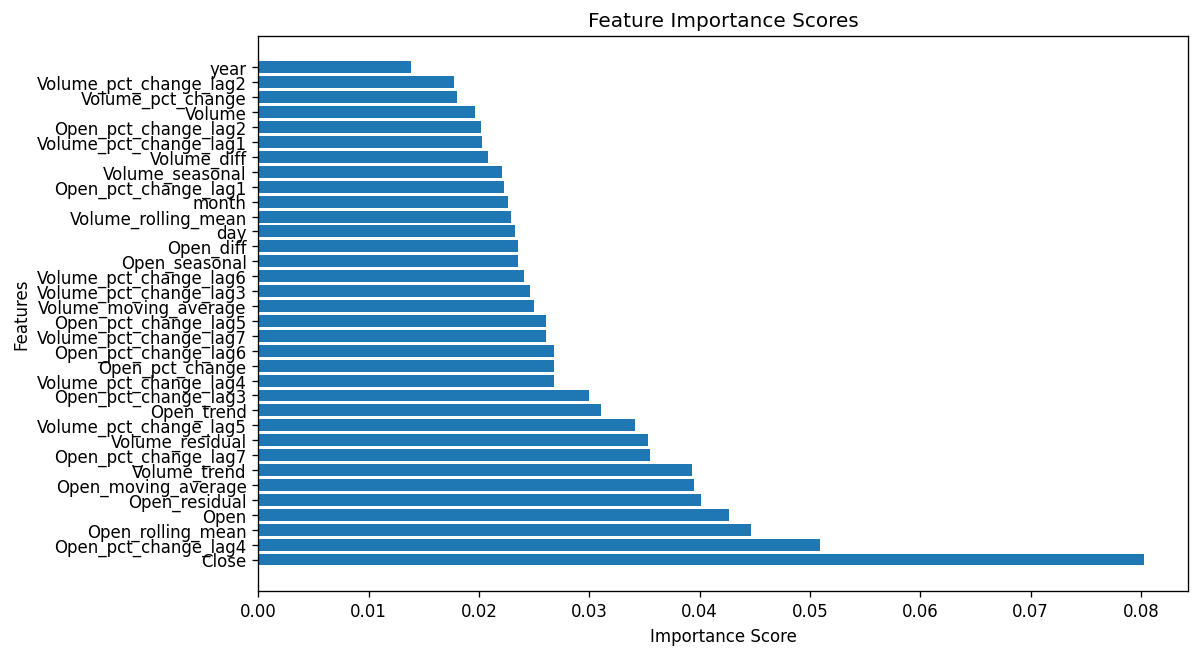

In [39]:
# Create and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0)
clf.fit(X_train, y_train)
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Scores')
plt.show()

In [40]:
for col in ['Close']:

    result = seasonal_decompose(train[col], model='multiplicative')
    train[f'{col}_trend'] = result.trend
    train[f'{col}_trend'].interpolate(method='linear', inplace=True)
    train[f'{col}_trend'].interpolate(method='linear', limit_direction='backward', inplace=True)
    train[f'{col}_seasonal'] = result.seasonal
    train[f'{col}_residual'] = result.resid
    train[f'{col}_residual'].interpolate(method='linear', inplace=True)
    train[f'{col}_residual'].interpolate(method='linear', limit_direction='backward', inplace=True)

In [41]:
for col in ['Close']:
    result = seasonal_decompose(test[col], model='multiplicative', period=int(len(test)/2))
    test[f'{col}_trend'] = result.trend
    test[f'{col}_trend'].interpolate(method='linear', inplace=True)
    test[f'{col}_trend'].interpolate(method='linear', limit_direction='backward', inplace=True)
    test[f'{col}_seasonal'] = result.seasonal
    test[f'{col}_residual'] = result.resid
    test[f'{col}_residual'].interpolate(method='linear', inplace=True)
    test[f'{col}_residual'].interpolate(method='linear', limit_direction='backward', inplace=True)

In [42]:
# percentage change lags
train["Close_pct_change"] = train["Close"].pct_change() * 100
train["Close_pct_change"].fillna(method='bfill', inplace=True)

test["Close_pct_change"] = test["Close"].pct_change() * 100
test["Close_pct_change"].fillna(method='bfill', inplace=True)

#lag_periods = 7  # Adjust the lag period as needed
for lag_periods in range(1,8):
    for col in ['Close_pct_change']:
        train[f'{col}_lag{lag_periods}'] = train[col].shift(lag_periods)
        train[f'{col}_lag{lag_periods}'].fillna(method='bfill', inplace=True)

        test[f'{col}_lag{lag_periods}'] = test[col].shift(lag_periods)
        test[f'{col}_lag{lag_periods}'].fillna(method='bfill', inplace=True)

<ipython-input-42-1b1b650d0313>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train["Close_pct_change"].fillna(method='bfill', inplace=True)
<ipython-input-42-1b1b650d0313>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test["Close_pct_change"].fillna(method='bfill', inplace=True)
<ipython-input-42-1b1b650d0313>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[f'{col}_lag{lag_periods}'].fillna(method='bfill', inplace=True)
<ipython-input-42-1b1b650d0313>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[f'{col}_lag{lag_periods}'].fillna(method='bfill', inplace=True)
<ipython-input-42-1b1b650d0313>:12: FutureWarning: Ser

In [43]:
# Calculate rolling means for 'Close"
window_size = 7  # Adjust the window size as needed
for col in ['Close']:
    train[f'{col}_rolling_mean'] =train[col].rolling(window=window_size).mean()
    train[f'{col}_rolling_mean'].fillna(method='bfill', inplace=True)

    test[f'{col}_rolling_mean'] =test[col].rolling(window=window_size).mean()
    test[f'{col}_rolling_mean'].fillna(method='bfill', inplace=True)

<ipython-input-43-a8159cea235b>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[f'{col}_rolling_mean'].fillna(method='bfill', inplace=True)
<ipython-input-43-a8159cea235b>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[f'{col}_rolling_mean'].fillna(method='bfill', inplace=True)


In [44]:
# Create differenced values for CLose
for col in ['Close']:
    train[f'{col}_diff'] =train[col].diff()
    train[f'{col}_diff'].fillna(method='bfill', inplace=True)

    test[f'{col}_diff'] =test[col].diff()
    test[f'{col}_diff'].fillna(method='bfill', inplace=True)

<ipython-input-44-49d6de66fdb8>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[f'{col}_diff'].fillna(method='bfill', inplace=True)
<ipython-input-44-49d6de66fdb8>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[f'{col}_diff'].fillna(method='bfill', inplace=True)


In [45]:
# Calculate moving averages for 'Close'
ma_window_size = 8  # Adjust the moving average window size as needed
for col in ['Close']:
    train[f'{col}_moving_average'] = train[col].rolling(window=ma_window_size).mean()
    train[f'{col}_moving_average'].fillna(method='bfill', inplace=True)

    test[f'{col}_moving_average'] = test[col].rolling(window=ma_window_size).mean()
    test[f'{col}_moving_average'].fillna(method='bfill', inplace=True)

<ipython-input-45-2e049fc93b6c>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[f'{col}_moving_average'].fillna(method='bfill', inplace=True)
<ipython-input-45-2e049fc93b6c>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[f'{col}_moving_average'].fillna(method='bfill', inplace=True)


In [46]:
test.columns

Index(['id', 'Open', 'Volume', 'Open_pct_change', 'Volume_pct_change',
       'Open_pct_change_lag1', 'Volume_pct_change_lag1',
       'Open_pct_change_lag2', 'Volume_pct_change_lag2',
       'Open_pct_change_lag3', 'Volume_pct_change_lag3',
       'Open_pct_change_lag4', 'Volume_pct_change_lag4',
       'Open_pct_change_lag5', 'Volume_pct_change_lag5',
       'Open_pct_change_lag6', 'Volume_pct_change_lag6',
       'Open_pct_change_lag7', 'Volume_pct_change_lag7', 'Open_rolling_mean',
       'Volume_rolling_mean', 'Open_diff', 'Volume_diff',
       'Open_moving_average', 'Volume_moving_average', 'year', 'month', 'day',
       'Open_trend', 'Open_seasonal', 'Open_residual', 'Volume_trend',
       'Volume_seasonal', 'Volume_residual', 'Close', 'Close_trend',
       'Close_seasonal', 'Close_residual', 'Close_pct_change',
       'Close_pct_change_lag1', 'Close_pct_change_lag2',
       'Close_pct_change_lag3', 'Close_pct_change_lag4',
       'Close_pct_change_lag5', 'Close_pct_change_lag6'

RFE with Logistic Regression
RFE takes in a integer as parameter and gived out that many featurs that are significant for prediction with the model passed as the second argument (pretty useful)

In [47]:
train.columns

Index(['id', 'Open', 'Close', 'Volume', 'Strategy', 'Open_pct_change',
       'Volume_pct_change', 'Open_pct_change_lag1', 'Volume_pct_change_lag1',
       'Open_pct_change_lag2', 'Volume_pct_change_lag2',
       'Open_pct_change_lag3', 'Volume_pct_change_lag3',
       'Open_pct_change_lag4', 'Volume_pct_change_lag4',
       'Open_pct_change_lag5', 'Volume_pct_change_lag5',
       'Open_pct_change_lag6', 'Volume_pct_change_lag6',
       'Open_pct_change_lag7', 'Volume_pct_change_lag7', 'Open_rolling_mean',
       'Volume_rolling_mean', 'Open_diff', 'Volume_diff',
       'Open_moving_average', 'Volume_moving_average', 'year', 'month', 'day',
       'Open_trend', 'Open_seasonal', 'Open_residual', 'Volume_trend',
       'Volume_seasonal', 'Volume_residual', 'Close_trend', 'Close_seasonal',
       'Close_residual', 'Close_pct_change', 'Close_pct_change_lag1',
       'Close_pct_change_lag2', 'Close_pct_change_lag3',
       'Close_pct_change_lag4', 'Close_pct_change_lag5',
       'Close_pct_

RFE with Logistic Regression
RFE takes in a integer as parameter and gived out that many featurs that are significant for prediction with the model passed as the second argument (pretty useful)

In [48]:
X_train = train.loc[:, train.columns.difference(['id', 'Open', 'Close', 'Volume', "Strategy", "year", "month", "day"])]

y_train = train['Strategy']

X_test = test.loc[:, test.columns.difference(['id', 'Open', 'Close', 'Volume', "Strategy", "year", "month", "day"])]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
classifier = LogisticRegression(penalty='l2', solver='liblinear', max_iter=100000)

In [50]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
}

# Perform hyperparameter tuning with cross-validation
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_c = grid_search.best_params_['C']

In [51]:
classifier = LogisticRegression(penalty='l2', solver='liblinear', C=best_c, max_iter=10000)


In [52]:
num_features_to_select = 11  # You can choose the number of features you want to keep
rfe = RFE(classifier, n_features_to_select=num_features_to_select)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(C=100, max_iter=10000, solver='liblinear'),
    n_features_to_select=11)

In [53]:
RFE(estimator=LogisticRegression(C=100, max_iter=10000, solver='liblinear'),
    n_features_to_select=11)

RFE(estimator=LogisticRegression(C=100, max_iter=10000, solver='liblinear'),
    n_features_to_select=11)

In [54]:

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

classifier.fit(X_train_rfe, y_train)
y_pred = classifier.predict(X_test_rfe)

In [55]:
selected_features = rfe.support_
original_column_names = train.loc[:, train.columns.difference(['id', 'Open', 'Close', 'Volume', "Strategy", "year", "month", "day"])].columns

# Get the selected feature names
selected_feature_names = original_column_names[selected_features]

print("Selected Features:", selected_feature_names)
print("Best C (Regularization Strength):", best_c)

Selected Features: Index(['Close_diff', 'Close_moving_average', 'Close_pct_change',
       'Close_pct_change_lag1', 'Close_trend', 'Open_moving_average',
       'Open_pct_change', 'Open_residual', 'Open_rolling_mean', 'Open_trend',
       'Volume_trend'],
      dtype='object')
Best C (Regularization Strength): 100


In [56]:
y_pred

array(['Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy',
       'Buy', 'Buy', 'Hold', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold',
       'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Sell',
       'Sell', 'Sell', 'Sell', 'Hold', 'Hold', 'Hold', 'Sell', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Hold', 'Sell', 'Sell',
       'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Sell', 'Hold',
       'Sell', 'Sell', 'Hold', 'Sell', 'Sell', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy'], dtype=object)

In [57]:
sub_df = pd.DataFrame()
sub_df["id"] = test["id"]
sub_df["Date"] = test.index
sub_df["Close"] = test["Close"]
sub_df["Strategy"] = y_pred
sub_df.to_csv("Submission.csv", index = False)